Create a model to make predictions.



# The problem

A dataset of customers who have applied for credit is given.
Each customer is associated with some number of attributes, and a rating of being a Good/Bad credit risk.

## The dataset

- The dataset is given in the file "credit_data.csv".
- Each row corresponds to one customer.
- There are 20 attributes, some numeric and some categorical.
- The last column "Credit Risk" encodes whether the customer was judged to be a Good/Bad credit risk
    - 1: Good credit risk
    - 2: Bad credit risk

You will use this data to come up with a model that predicts "Credit Risk" for a customer from the customer's attributes.

### Attributes

A description of the attributes is given in the plain text file "credit_data_attributes.txt".

You will notice that the values for many attributes are encoded as strings.
For example, attribute 7 is the customer's Employment Status, having possible values
A71, A72, .., A75.  Per the file, "A71" means the customer is unemployed.

#### Currency

The currency units are "DM" (old German currency: the Deutsche Mark).

As you might guess: this data is not recent; you may find anachronisms other than the currency.

# Getting the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [2]:
train_data=pd.read_csv("credit_data.csv")
train_data.head()

,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8,Attribute 9,Attribute 10,...,Attribute 12,Attribute 13,Attribute 14,Attribute 15,Attribute 16,Attribute 17,Attribute 18,Attribute 19,Attribute 20,Credit Risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


We can see the attributes in credit_data_attributes.txt and figure out qualitative attributes and numetical attributes.

In [3]:
f=open("credit_data_attributes.txt","r")
print(f.read())

Attribute 1:  (qualitative)
	       Status of existing checking account
               A11 :      ... <    0 DM
	       A12 : 0 <= ... <  200 DM
	       A13 :      ... >= 200 DM /
		     salary assignments for at least 1 year
               A14 : no checking account

Attribute 2:  (numerical)
	      Duration in month

Attribute 3:  (qualitative)
	      Credit history
	      A30 : no credits taken/
		    all credits paid back duly
              A31 : all credits at this bank paid back duly
	      A32 : existing credits paid back duly till now
              A33 : delay in paying off in the past
	      A34 : critical account/
		    other credits existing (not at this bank)

Attribute 4:  (qualitative)
	      Purpose
	      A40 : car (new)
	      A41 : car (used)
	      A42 : furniture/equipment
	      A43 : radio/television
	      A44 : domestic appliances
	      A45 : repairs
	      A46 : education
	      A47 : (vacation - does not exist?)
	      A48 : retraining
	      A49 : business
	 

In [4]:
def plot_attrs(df, attrs, attr_type="Cat", normalize=True, plot=True):
    """
    Plot/print the distribution of one or more attributes of DataFrame
    
    Parameters
    ----------
    df: DataFrame
    attrs: List of attributes (i.e., column names)
    
    Optional
    --------
    attr_type: String; 
      "Cat" to indicate that the attributes in attrs are Categorical (so use value_counts)
      Otherwise: the attributes must be numeric columns (so use histogram)
    """
    num_attrs = len(attrs)
    ncols=2
    nrows = max(1,round(num_attrs/ncols))
    if num_attrs==1:
        fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(4, num_attrs*3))
    else:
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, num_attrs*3))
    # Make sure axes is an array (special case when num_attrs==1)
    if num_attrs == 1:
        axes =np.array( [ axes ])
        
    for i, attr in enumerate(attrs):
        if attr_type == "Cat":
            alpha_bar_chart = 0.55
            plot_data = df.loc[:, attr ].value_counts(normalize=normalize).sort_index()
            
            args = { "kind":"bar" } #, "alpha":alpha_bar_chart}
            kind="bar"
        else:
            plot_data = df.loc[:, [attr] ]
            
            args = { "kind":"hist"}
            if normalize:
                args["density"] = True
            kind="hist"
            
        if plot:
            _ = plot_data.plot(title=attr, ax=axes.flatten()[i], **args)
        else:
            print(attr + "\n")
            print(plot_data)
            print("\n")

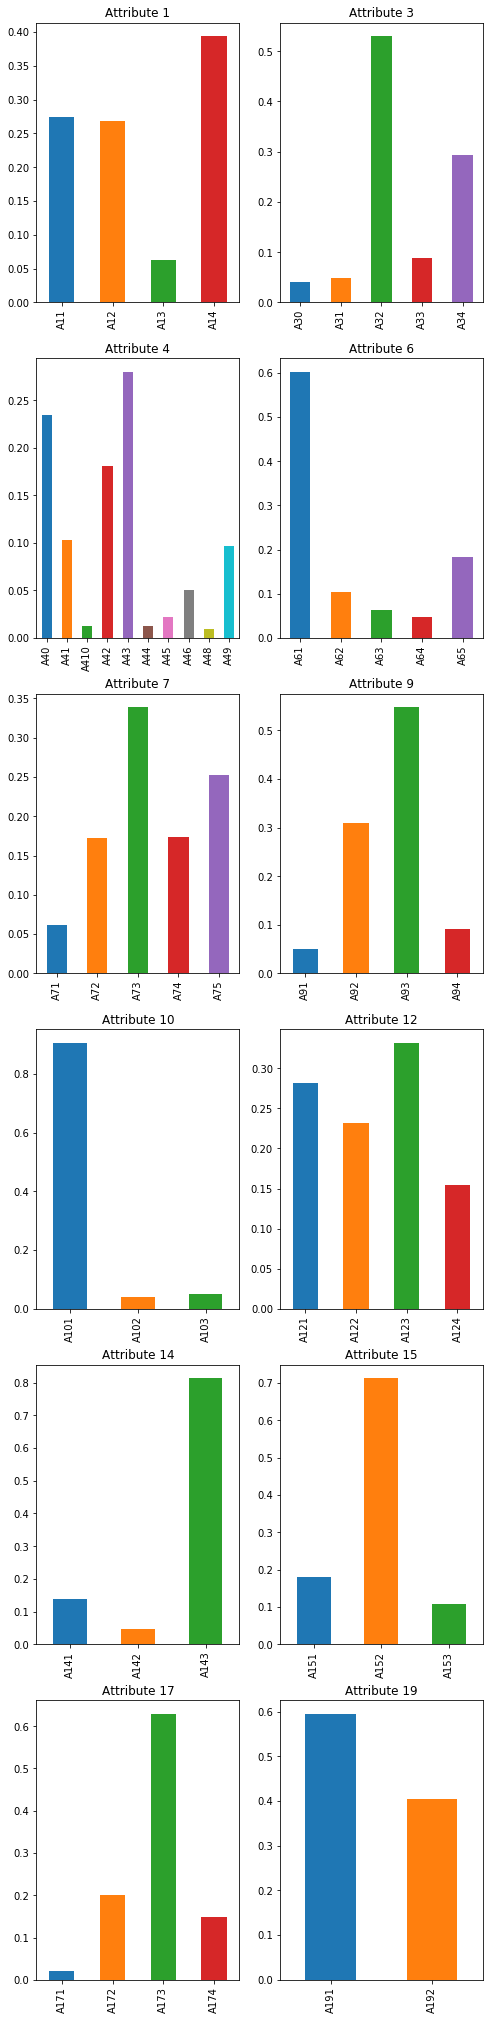

In [5]:
plot_attrs(train_data, ["Attribute 1","Attribute 3","Attribute 4","Attribute 6","Attribute 7","Attribute 9" ,"Attribute 10","Attribute 12","Attribute 14","Attribute 15","Attribute 17","Attribute 19"], attr_type="Cat", plot=True)
 

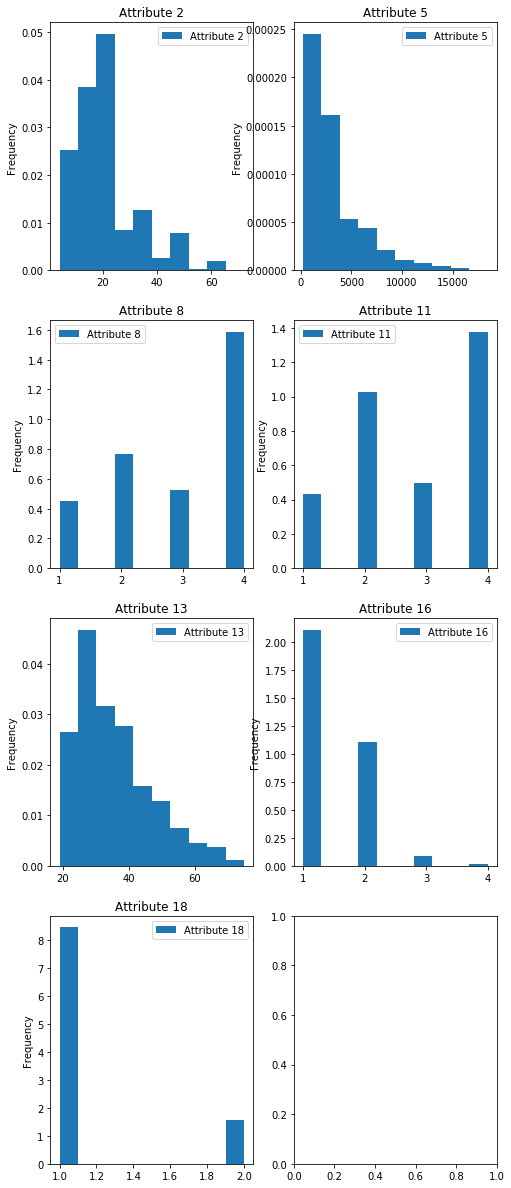

In [6]:
plot_attrs(train_data,["Attribute 2","Attribute 5","Attribute 8" ,"Attribute 11","Attribute 13","Attribute 16","Attribute 18"],attr_type="Num")

# Data Processing

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

- Make two pipelines of category data for baseline model and random forest model and a pipeline of numerical data.
- Then we use feature union to get dataframe which we make it an array to enhance processing efficiency.

## category data

- AxxToInt:transform category data into int 
- Array_Dummy_Drop:use onehotcoder to creat dummy variables and drop one to aviod collinearity.

In [8]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


class AxxToInt(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self    
    def transform(self, X, y=None):
        for i,ch in enumerate(X):
            for j,ch_1 in enumerate(ch):
                X[i][j]=int(ch_1[1:])
        return X

class Array_Dummy_Drop(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self    
    def transform(self, X, y=None):
        X=X.T
        res  = OneHotEncoder(sparse=False,categories='auto').fit_transform(X[0].T.reshape(-1,1))
        res = np.delete(res,0,1)
        for i,ch in enumerate(X[1:]):
            temp=OneHotEncoder(sparse=False,categories='auto').fit_transform(X[i].T.reshape(-1,1))
            temp=np.delete(temp,0,1)
            res=np.concatenate((res,temp),axis=1)
        return res
    
cat_features = ["Attribute 1","Attribute 3","Attribute 4","Attribute 6","Attribute 7","Attribute 9" ,"Attribute 10","Attribute 12","Attribute 14","Attribute 15","Attribute 17","Attribute 19","Attribute 20"]
           

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(cat_features)),
        ("Axx_encoder",AxxToInt() ),
        ("Dummy_Drop",Array_Dummy_Drop() )
    
    ])#for baseline model
    
cat_pipeline_1 = Pipeline([
        ("select_cat", DataFrameSelector(cat_features)),
        ("Axx_encoder",AxxToInt() ),
    
    ])#for randomforest model

- cat_pipeline: Include dummy variables for baseline model.
- cat_pipeline_1: Not include dummy variables for random forest model.

## numeric data

In [9]:
num_features = ["Attribute 2","Attribute 5","Attribute 8" ,"Attribute 11","Attribute 13","Attribute 16","Attribute 18"]
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector( num_features )),
    ])           


## features union

In [10]:
preprocess_pipeline= FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

X_train_base = preprocess_pipeline.fit_transform(train_data)
y_train=train_data['Credit Risk']
print(X_train_base.shape)
X_train_base


(1000, 50)


array([[6.000e+00, 1.169e+03, 4.000e+00, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       [4.800e+01, 5.951e+03, 2.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.200e+01, 2.096e+03, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.200e+01, 8.040e+02, 4.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [4.500e+01, 1.845e+03, 4.000e+00, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       [4.500e+01, 4.576e+03, 3.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

# Baseline model

In [11]:
from sklearn import linear_model, preprocessing, model_selection 
from sklearn.model_selection import cross_val_score
logistic_clf = linear_model.LogisticRegression(solver='liblinear')
SCORE = cross_val_score(logistic_clf,X_train_base,y_train, cv=5, scoring = "accuracy")
SCORE=SCORE.mean()
SCORE

0.752

- After evaluating the score of the model, we also have to use confusion matrix to see the prediction bias.

Confusion matrix, without normalization


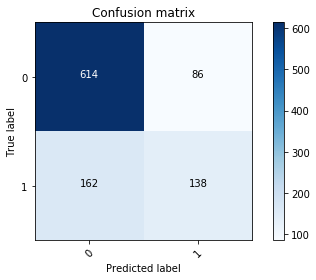

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn import datasets, svm, metrics
from sklearn.metrics import precision_recall_curve



# %load mnist_plot_confusion.py
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        # Normalize by row sums
        cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around( 100 * cm_pct, decimals=0).astype(int)
        
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Plot coordinate system has origin in upper left corner
        # -  coordinates are (horizontal offset, vertical offset)
        # -  so cm[i,j] should appear in plot coordinate (j,i)
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


expected= y_train
predicted = cross_val_predict(logistic_clf, X_train_base, y_train, cv=5)

confusion_mat_l = metrics.confusion_matrix(expected, predicted)
plot_confusion_matrix(confusion_mat_l, range(2))

In [13]:
a1=confusion_mat_l[0][0]/(confusion_mat_l[0][0]+confusion_mat_l[0][1])
print("prediction accuracy for good credit customer {a1}".format(a1=a1))
a2=confusion_mat_l[1][1]/(confusion_mat_l[1][1]+confusion_mat_l[1][0])
print("prediction accuracy for bad credit customer {a2}".format(a2=a2))

prediction accuracy for good credit customer 0.8771428571428571
prediction accuracy for bad credit customer 0.46


- We can find that a customer who is a Bad credit risk can be easily misjudged to be a Good credit risk.
- This is because target data is not balanced. In random forest model,we implement class weight balanced.

# Random forest model

## feature union

In [14]:
preprocess_pipeline_1= FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline1", cat_pipeline_1),
    ])

X_train_base_1 = preprocess_pipeline_1.fit_transform(train_data)


In [15]:
from sklearn.model_selection import train_test_split
X_train_1, X_test, y_train_1, y_test = train_test_split(X_train_base_1, y_train, test_size=0.2, random_state=0)
print('Before OverSampling,the shape of X_train_1:{}'.format(X_train_1.shape))
print('Before OverSampling,the shape of y_train_1:{}\n'.format(y_train_1.shape))
print('Before OverSampling,counts of lable "1":{}'.format(sum(y_train_1==1)))
print('Before OverSampling,counts of lable "2":{}'.format(sum(y_train_1==2)))


Before OverSampling,the shape of X_train_1:(800, 20)
Before OverSampling,the shape of y_train_1:(800,)

Before OverSampling,counts of lable "1":558
Before OverSampling,counts of lable "2":242


In [16]:
from sklearn.ensemble import RandomForestClassifier

credit_model_0= RandomForestClassifier(n_estimators=100,max_depth=5,random_state=0) 
credit_model_0.fit(X_train_1,y_train_1)
credit_model_0.score(X_test,y_test)

0.74

Confusion matrix, without normalization


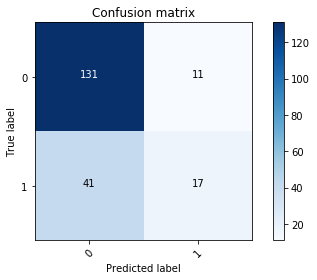

In [17]:
expected= y_test
predicted=credit_model_0.predict(X_test)
confusion_mat_0 = metrics.confusion_matrix(expected, predicted)
plot_confusion_matrix(confusion_mat_0, range(2))

In [18]:
a1=confusion_mat_0[0][0]/(confusion_mat_0[0][0]+confusion_mat_0[0][1])
print("prediction accuracy for good credit customer {a1}".format(a1=a1))
a2=confusion_mat_0[1][1]/(confusion_mat_0[1][1]+confusion_mat_0[1][0])
print("prediction accuracy for bad credit customer {a2}".format(a2=a2))

prediction accuracy for good credit customer 0.9225352112676056
prediction accuracy for bad credit customer 0.29310344827586204


We can see that in random forest model, imbalanced data makes confusion matrix worse although model accuracy is almost the same as baseline model.

In order to settle the imbalance problem we use SMOTE, which is an oversampling method.

- "SMOTE" : (Synthetic Minority Oversampling Technique ) which increase the number of samples of under sampled data. In this case, we increase the number of the Bad Credit and make two kinds of people same in training data.

In [19]:
from imblearn.over_sampling import SMOTE

sm=SMOTE(random_state=0)

X_train_res,y_train_res=sm.fit_sample(X_train_1,y_train_1.ravel())

print('After OverSampling,the shape of X_train_1:{}'.format(X_train_1.shape))
print('After OverSampling,the shape of y_train_1:{}\n'.format(y_train_1.shape))
print('After OverSampling,counts of lable "1":{}'.format(sum(y_train_res==1)))
print('After OverSampling,counts of lable "2":{}'.format(sum(y_train_res==2)))


After OverSampling,the shape of X_train_1:(800, 20)
After OverSampling,the shape of y_train_1:(800,)

After OverSampling,counts of lable "1":558
After OverSampling,counts of lable "2":558


We split the data sample and use 20% data in the sample as testing sample. 
We can see counts of lable "1" and counts of lable "2" are the same after oversampling. So after solve the sample data imbalance problem, we can use randomforestclassifier to establish the credit model.

In [20]:
credit_model= RandomForestClassifier(n_estimators=100,max_depth=5,random_state=0) 
credit_model.fit(X_train_res,y_train_res)
credit_model.score(X_test,y_test)

0.725

Confusion matrix, without normalization


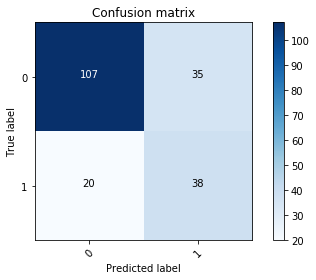

In [21]:
expected= y_test
predicted=credit_model.predict(X_test)
confusion_mat = metrics.confusion_matrix(expected, predicted)
plot_confusion_matrix(confusion_mat, range(2))

In [22]:
a1=confusion_mat[0][0]/(confusion_mat[0][0]+confusion_mat[0][1])
print("prediction accuracy for good credit customer {a1}".format(a1=a1))
a2=confusion_mat[1][1]/(confusion_mat[1][1]+confusion_mat[1][0])
print("prediction accuracy for bad credit customer {a2}".format(a2=a2))

prediction accuracy for good credit customer 0.7535211267605634
prediction accuracy for bad credit customer 0.6551724137931034


####  Conclusion of random forest model:
- We can see the score of the random forest model is lower than that of baseline model. But we can see the improvement of confusion matrix. 
- In real life, it's worse when we classify a bad credit customer mistakenly as a good credit customer rather than classifying a good credit customer as a bad credit customer because the former one is the resource of credit risk.
- By using oversampling, we increase the weight of the bad credit customer sample data which makes it better to evaluate the credit of all customers.

# summary

- It is obvious that Logistic Model is not a good choice to predict the credit of a customer because there are many category variables.
- Randomforest Model without oversampling makes a good prediction on good credit customers but performance on prediction of bad credit customers is really bad.
- After oversampling, accuracy of Randomforest Model falls a bit but confusion matrix is improved a lot which shows the importance of balance weights of good credit customers data and bad credit customers data.
- To sum up, in order to make better prediction in real life, we have to focus on data balance instead of just paying much attention to accuracy of models.

# testing place

- Input X_testing_data and y_testing_data. 
- Use credit_model.predict(X_testing_data) to do prediction.
- Use credit_model.score(X_testing_data,y_testing_data) to see accuracy.